# LEXA

In [ ]:
import numpy as np
from copy import deepcopy


In [71]:
class SimplexTableau:
    def __init__(self, obj_coefs, free_coef, optimization_dir='min', A_uneq=None, \
                 b_uneq=None, uneq_types=None, A_eq=None, b_eq=None, v_con=None):

      self.obj_coefs = np.array(obj_coefs)
      self.free_coef = free_coef
      self.optimization_dir = optimization_dir
      self.vars_constraints = vars_cotynstraints
      self.initial_vars = list(range(len(obj_coefs)))
      self.arbitrary_vars_map = dict()
      if A_uneq is not None:
        self.A_uneq = np.array([A_uneq])
        self.b_uneq = np.array(b_uneq)
        self.uneq_types = uneq_types
      else:
        self.A_uneq = None

      if A_eq is not None:
        self.A_eq = np.array(A_eq)
        self.b_eq = np.array(b_eq)
      else:
        self.A_eq = None

    def cannonize_b(self):
      mask = self.b < 0
      self.b = np.where(self.b >= 0, self.b, -self.b).ravel()
      self.A[mask] *= -1
      return self

    def cannonize_arb_var(self):
      k = len(self.vars_constraints)
      for i, var_constr in enumerate(self.v_con):
          if var_constr == '<=':
              self.arbitrary_vars_map[i] = [i]
              if self.A_eq is not None:
                  self.A_eq[:, i] *= -1
              if self.A_uneq is not None:
                  self.A_uneq[:, i] *= -1
              self.obj_coefs[i] *= -1
          elif var_constr == 'n_c':
              self.arbitrary_vars_map[i] = [i, k]
              if self.A_eq is not None:
                  self.A_eq = np.hstack((self.A_eq, -self.A_eq[:, i].reshape(-1, 1)))
              if self.A_uneq is not None:
                  self.A_uneq = np.hstack((self.A_uneq, -self.A_uneq[:, i].reshape(-1, 1)))
              new_obj = np.empty((len(self.obj_coefs)+1,))
              new_obj[:len(self.obj_coefs)] = self.obj_coefs
              new_obj[-1] = -self.obj_coefs[i]
              self.obj_coefs = new_obj
              k += 1
      return self

    def cannonize_uneq(self):
      new_coefs = np.diag(np.where(np.array(self.uneq_types) == '<=', 1, -1))
      self.num_base_init = len(new_coefs)
      self.A_uneq = np.hstack((self.A_uneq, new_coefs))
      if self.A_eq is not None:
          self.A_eq = np.hstack((self.A_eq, np.zeros(len(self.A_eq), new_coefs.shape[1])))
      self.obj_coefs = np.hstack((self.obj_coefs, np.zeros((new_coefs.shape[1],))))
      if self.A_eq is not None:
          self.A = np.vstack((self.A_uneq, self.A_eq))
          self.b = np.vstack((self.b_uneq, self.b_eq))
      else:
          self.A = self.A_uneq
          self.b = self.b_uneq
      return self

    def canonize(self):
      if self.optimization_dir == 'max':
          self.obj_coefs *= -1
          self.free_coef *= -1
      if self.vars_constraints is not None:
          self.cannonize_arb_var()

      if self.A_uneq is not None:
          self.cannonize_uneq()
      else:
          self.A = self.A_eq
          self.b = self.b_eq

      if (self.b < 0).any():
          self.cannonize_b()
      self.var_inds = np.arange(self.A.shape[1])
      return self

    def artificial_basis(self, i_col, A, b_col, art):
      arts_in_basis = np.in1d(i_col, art)
      all_zeros = np.all(A == 0, axis=0)
      z_mask = np.bitwise_and(arts_in_basis, all_zeros)
      if z_mask.any():
          A = A[z_mask]
          b_col = b_col[z_mask]
          i_col = i_col[z_mask]
      if np.in1d(i_col, art).any():
          for i, row in enumerate(A):
              if not np.in1d(i_col, art)[i]:
                  continue
              else:
                  art_pivot_coords = (i, np.arange(len(row))[row!=0][0])
      else:
          art_pivot_coords = 0
      return A, b_col, i_col, art_pivot_coords

    def simplex_step(self, i_col, j_row, A, p_row, b_col, Q0, art = None, pivot_elem = None):
      pivot_col = np.argmin(p_row)
      #2stepb
      if p_row[pivot_col] < 0 or pivot_elem is not None: 
          if np.max(A[:, pivot_col]) < 0 and pivot_elem is None:
              return i_col, j_row, A, p_row, b_col, Q0, 0, None
          else:
              if pivot_elem is None:
                  b_a = np.argsort(b_col / A[:, pivot_col])
                  for i in b_a:
                      if A[i, pivot_col] > 0:
                          pivot_row = i
                          break
                      else:
                          return i_col, j_row, A, p_row, b_col, Q0, 0, None
              else:
                  pivot_row, pivot_col = pivot_elem

              pivot_a = A[pivot_row, pivot_col]
              new_i_col = deepcopy(i_col)
              new_j_row = deepcopy(j_row)
              new_i_col[pivot_row] = j_row[pivot_col]
              new_j_row[pivot_col] = i_col[pivot_row]
              pivot_a_hat = 1 / pivot_a
              a_col_pivot_hat = -A[:, pivot_col] * pivot_a_hat
              pivot_p_hat = - p_row[pivot_col] * pivot_a_hat
              a_row_pivot_hat = A[pivot_row] * pivot_a_hat
              pivot_b_hat = b_col[pivot_row] * pivot_a_hat
              new_A = A - A[:, pivot_col].reshape(-1, 1).dot(a_row_pivot_hat.reshape(1, -1))
              new_A[:, pivot_col] = a_col_pivot_hat
              new_A[pivot_row] = a_row_pivot_hat
              new_A[pivot_row, pivot_col] = pivot_a_hat
              new_p_row = p_row - a_row_pivot_hat * p_row[pivot_col]
              new_p_row[pivot_col] = pivot_p_hat
              new_b_col = b_col - pivot_b_hat * A[:, pivot_col]
              new_b_col[pivot_row] = pivot_b_hat
              new_Q0 = Q0 - pivot_b_hat * p_row[pivot_col]

              if art is not None:
                  mask = ~np.in1d(new_j_row, art)
                  new_A = new_A[:, mask]
                  new_p_row = new_p_row[mask]
                  new_j_row = new_j_row[mask]
                  if np.isclose(new_Q0, 0) and not np.in1d(new_i_col, art).any():
                      return new_i_col, new_j_row, new_A, new_p_row, new_b_col, new_Q0, 1, None
                  elif np.isclose(new_Q0, 0) and np.in1d(new_i_col, art).any():
                      new_A, new_b_col, new_i_col, art_pivot_coords = self.artificial_basis(i_col, A, b_col, art)
                      return new_i_col, new_j_row, new_A, new_p_row, new_b_col, new_Q0, None, art_pivot_coords
              return new_i_col, new_j_row, new_A, new_p_row, new_b_col, new_Q0, None, None
      elif p_row[pivot_col] >= 0 and art is not None:
          if Q0 < 0:
              return i_col, j_row, A, p_row, b_col, Q0, 0, None
      else:
          return i_col, j_row, A, p_row, b_col, Q0, 1, None

    def transform_to_base(self):
      
      indep_cols = []
      base_rows = []

      # col with 1?
      for i in range(self.A.shape[1]):
          if (self.A[:, i] != 0).sum() == 1:
              br = np.where(np.array(self.A[:, i]) != 0)[0][0]
              if br not in base_rows and self.A[br, i] > 0:
                  base_rows.append(br)
                  self.b[br] = self.b[br] / self.A[br, i]
                  self.A[br] /= self.A[br, i]
                  indep_cols.append(i)
          if len(indep_cols) == self.A.shape[0]:
              for j, i in zip(indep_cols, base_rows):
                  self.free_coef += self.obj_coefs[j] * self.b[i]
                  self.obj_coefs -= (self.obj_coefs[j] * self.A[i]).astype(float)

              return indep_cols, base_rows
      else:
          print("Secondary task is needed")
          return 0, 0

    def add_artificial_vars(self):
      A_art = np.hstack((self.A, np.eye(self.A.shape[0])))
      g_fun = -np.sum(self.A, axis=0)
      g0 = -self.b.sum()
      return A_art, g_fun, g0

    def solve(self, num_iterations=100):

      self.canonize()
      self.A = self.A.astype(float)
      self.b = self.b.astype(float)
      i_col, base_rows = self.transform_to_base()

      if i_col == 0:
          print('Additional task')
          A_art, g, g0 = self.add_artificial_vars()
          i_col = np.arange(self.A.shape[1], A_art.shape[1])
          j_row = np.arange(self.A.shape[1])
          A = self.A
          p_row = g
          b_col = self.b
          Q0 = g0
          arts = np.arange(self.A.shape[0])+self.A.shape[1]
          art_piv_elem = None
          for i in range(num_iterations):
              res = self.simplex_step(i_col, j_row, A, p_row, b_col, Q0, arts, art_piv_elem)
              i_col, j_row, A, p_row, b_col, Q0, out, art_piv_elem = res
              if out == 0:
                  return "No solutions"
              elif out == 1:
                  b_count = 0
                  new_A = np.empty(self.A.shape)
                  new_A[:, j_row] = A
                  eye = np.eye(self.A.shape[0])
                  for col in range(self.A.shape[1]):
                      if col in i_col:
                          new_A[:, col] = eye[:, np.where(i_col==col)[0][0]]
                          b_count+=1
                  for i, j in enumerate(i_col):
                      self.free_coef += self.obj_coefs[j] * b_col[i]
                      self.obj_coefs -= (self.obj_coefs[j] * new_A[i]).astype(float)
                  break

      else:
          j_row = np.array([j for j in range(self.A.shape[1]) if j not in i_col]).ravel()
          A = self.A[:, j_row][base_rows]
          i_col = np.array(i_col)
          b_col = self.b[base_rows]
      print('Main task')
      p_row = self.obj_coefs[j_row]
      Q0 = -self.free_coef
      for i in range(num_iterations):
          res = self.simplex_step(i_col, j_row, A, p_row, b_col, Q0)
          i_col, j_row, A, p_row, b_col, Q0, out, art_piv_elem = res
          if res[-2] == 0:
              return "No solution"
              break
          elif res[-2] == 1:
              solution_dict = dict()
              for j in j_row:
                  solution_dict[f'x{j}'] = 0
              for b, i in enumerate(i_col):
                  solution_dict[f'x{i}'] = round(b_col[b], 2)
              if self.arbitrary_vars_map:
                  for k, v in self.arbitrary_vars_map.items():
                      if len(v) == 1:
                          solution_dict[f'x{k}'] = -solution_dict[f'x{k}']
                      else:
                          solution_dict[f'x{v[0]}'] -= round(solution_dict[f'x{v[1]}'],2)
              fin_vars = deepcopy(list(solution_dict.keys()))
              for k in fin_vars:
                  num = int(k[1:])
                  if num not in self.initial_vars:
                      del solution_dict[f'x{num}']

              solution_dict =  dict(sorted(solution_dict.items(), key = lambda x: int(x[0][1:])))
              if self.optimization_dir == 'max':
                  solution_dict['Q_opt'] = round(Q0, 2)
              else:
                  solution_dict['Q_opt'] = -round(Q0, 2)
              return solution_dict

      return "iter limit"

In [109]:
sym = SimplexTableau(obj_coefs=np.array([-2, -3, -4]),
              free_coef=0,
              type_of_optimization='min',
              A_eq=np.array([[3, 2, 1],
                                [2, 5, 3]]),
              b_eq=np.array([10, 15]),
              vars_constraints=['n_c', '>=', 'n_c'])

In [110]:
sym.solve()

Additional task
A: [[ 3.  2.  1. -3. -1.]
 [ 2.  5.  3. -2. -3.]]
i*: [5 6]
j*: [0 1 2 3 4]
p: [-5. -7. -4.  5.  4.]
b: [10. 15.]
-Q0: -25.0


Main task
A: [[-0.09090909 -1.          0.09090909]
 [ 0.63636364  0.         -0.63636364]]
i*: [0 1]
j*: [2 3 4]
p: [-2.27272727  0.          2.27272727]
b: [1.81818182 2.27272727]
-Q0: 10.454545454545453




{'Q': -18.57, 'x0': 2.14, 'x1': 0, 'x2': 3.57}

In [108]:
sym = SimplexTableau(obj_coefs=np.array([2, 1, -1, 3, -1]),
                  free_coef=0,
                  A_eq=np.array([[3, 0, 2, 0, -1],
                                 [1, -1, 1, 0, 0],
                                 [1, 0, 1, 1, 0]]),
                  b_eq=np.array([12, 5, 6]),)
sym.solve()

Additional task
A: [[ 3.  0.  2.  0. -1.]
 [ 1. -1.  1.  0.  0.]
 [ 1.  0.  1.  1.  0.]]
i*: [5 6 7]
j*: [0 1 2 3 4]
p: [-5.  1. -4. -1.  1.]
b: [12.  5.  6.]
-Q0: -23.0


Main task
A: [[ 2. -1.]
 [-3.  1.]
 [ 1.  0.]]
i*: [0 2 3]
j*: [1 4]
p: [-9.  2.]
b: [2. 3. 1.]
-Q0: -4.000000000000002




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide


{'Q': -5.0, 'x0': 0.0, 'x1': 1.0, 'x2': 6.0, 'x3': 0, 'x4': 0}

# Plot

In [73]:
from scipy.spatial import HalfspaceIntersection, ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

def render_inequalities(halfspaces, feasible_point, xlim, ylim):
    hs = HalfspaceIntersection(np.array(halfspaces), np.array(feasible_point))
    fig = plt.figure()
    ax = fig.add_subplot('111', aspect='equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    x = np.linspace(*xlim, 100)

    for h in halfspaces:
        if h[1]== 0:
            ax.axvline(-h[2]/h[0], color="#2c3e50")
        else:
            ax.plot(x, (-h[2]-h[0]*x)/h[1], color="#2c3e50")
    x, y = zip(*hs.intersections)
    points = list(zip(x, y))
    convex_hull = ConvexHull(points)
    polygon = Polygon([points[v] for v in convex_hull.vertices], color="#34495e")
    ax.add_patch(polygon)
    ax.plot(x, y, 'o', color="#e67e22")

In [3]:

a = [
    [-1, 4, 1, 0],
    [2, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]
b = [13, 10, 0, 0]
x1, x2, x3, x4 = np.linalg.solve(a, b)
print('x1 =', x1)
print('x2 =', x2)

x1 = 3.0
x2 = 4.0


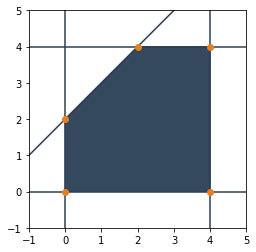

In [79]:
halfspaces = [
    [-1, 0, 0],    # x₁ ≥ 0
    [0, -1, 0],    # x₂ ≥ 0
    [-1, 1, -2],   # -x₁ + x₂ ≤ 2
    [1, 0, -4],    # x₁ ≤ 4
    [0, 1, -4],    # x₂ ≤ 4
]
feasible_point = np.array([0.5, 0.5])
xlim = (-1, 5)
render_inequalities(halfspaces, feasible_point, xlim, xlim)
plt.show()

In [5]:
c = [1, 1, 0, 0, 0]
A = [
    [-1, 1, 1, 0, 0],
    [ 1, 0, 0, 1, 0],
    [ 0, 1, 0, 0, 1]
]
b = [2, 4, 4]

In [6]:
def to_tableau(c, A, b):
    xb = [eq + [x] for eq, x in zip(A, b)]
    z = c + [0]
    return xb + [z]

In [7]:
def can_be_improved(tableau):
    z = tableau[-1]
    return any(x > 0 for x in z[:-1])

In [8]:
import math

def get_pivot_position(tableau):
    z = tableau[-1]
    column = next(i for i, x in enumerate(z[:-1]) if x > 0)
    
    restrictions = []
    for eq in tableau[:-1]:
        el = eq[column]
        restrictions.append(math.inf if el <= 0 else eq[-1] / el)
        
    if (all([r == math.inf for r in restrictions])):
        raise Exception("Linear program is unbounded.")

    row = restrictions.index(min(restrictions))
    return row, column

In [9]:
def pivot_step(tableau, pivot_position):
    new_tableau = [[] for eq in tableau]
    
    i, j = pivot_position
    pivot_value = tableau[i][j]
    new_tableau[i] = np.array(tableau[i]) / pivot_value
    
    for eq_i, eq in enumerate(tableau):
        if eq_i != i:
            multiplier = np.array(new_tableau[i]) * tableau[eq_i][j]
            new_tableau[eq_i] = np.array(tableau[eq_i]) - multiplier
   
    return new_tableau

In [10]:
def is_basic(column):
    return sum(column) == 1 and len([c for c in column if c == 0]) == len(column) - 1

def get_solution(tableau):
    columns = np.array(tableau).T
    solutions = []
    for column in columns[:-1]:
        solution = 0
        if is_basic(column):
            one_index = column.tolist().index(1)
            solution = columns[-1][one_index]
        solutions.append(solution)
        
    return solutions

In [11]:
def simplex(c, A, b):
    tableau = to_tableau(c, A, b)

    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)

    return get_solution(tableau)

In [12]:
solution = simplex(c, A, b)
print('solution: ', solution)

solution:  [4.0, 4.0, 2.0, 0, 0]


In [13]:
def get_objective_function_value(tableau):
    return -tableau[-1][-1]

In [14]:
def simplex_with_visualization(c, A, b, halfspaces, feasible_point):
    tableau = to_tableau(c, A, b)

    zs = [get_objective_function_value(tableau)]
    solutions = [get_solution(tableau)]
    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)
        solutions.append(get_solution(tableau))
        zs.append(get_objective_function_value(tableau))
    
    points = [v[:2] for v in solutions]
    xlim = (-1, max([p[0] for p in points]) + 1)
    ylim = (-1, max([p[1] for p in points]) + 1)
    render_inequalities(halfspaces, feasible_point, xlim, ylim)

    for start, end in zip(points[:-1], points[1:]):
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        if dx > 0 and dy > 0:
            plt.arrow(
                start[0],
                start[1],
                dx,
                dy,
                width=0.1,
                length_includes_head=True,
                color='#1abc9c'
            )
    plt.show()
    
    steps = range(len(zs))
    plt.plot(steps, zs, color="#2c3e50")
    plt.xticks(steps)
    plt.xlabel('iterations')
    plt.ylabel('objective function value')
    
    return get_solution(tableau)

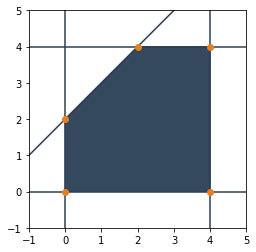

[4.0, 4.0, 2.0, 0, 0]

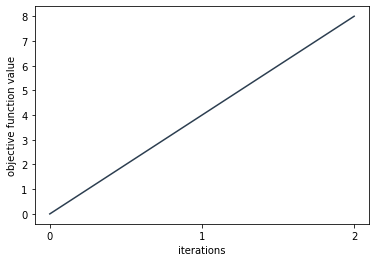

In [15]:
simplex_with_visualization(c, A, b, halfspaces, feasible_point)